# Import

In [ ]:
import os
import itertools
import numpy as np
import tensorflow as tf
%tensorflow_version 1.x
from scipy import io as spio
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# !rm -r *

TensorFlow is already loaded. Please restart the runtime to change versions.


# Functions

In [ ]:
class MyPlot():
    def __init__(self,
                 nrows, 
                 ncols, 
                 figsize):
        self.fig, self.axes = plt.subplots(nrows=nrows, 
                                           ncols=ncols, 
                                           figsize=figsize)

def my_histogram(ax, data, color, title=None):
    ax.hist(data, color=color, log=True, bins=25, edgecolor='black', linewidth=1.2);
    ax.set_title(title, color="white");

def plot_random_images(images, examples=16, fig_suptitle=None, figsize=(8,8), fpath=None):

    imgs_index = np.random.choice(np.arange(len(images)), examples, replace=False)

    plot = MyPlot(int(examples/np.sqrt(examples)), 
                  int(examples/np.sqrt(examples)), 
                  figsize=figsize)
    plot.axes = plot.axes.ravel()
    image_shape = images[0].shape
    for idx, _ in enumerate(plot.axes):
        X = images[imgs_index[idx]]
        if len(image_shape) == 2:
            plot.axes[idx].imshow(X=X,cmap="gray")
        else:
            plot.axes[idx].imshow(X=X)
        plot.axes[idx].axis('off')
    plot.fig.suptitle(fig_suptitle, fontsize=16)
    if fpath:
        plot.fig.savefig(fpath)

def plot_confusion_matrix(cm,
                          classes,
                          normalize=True,
                          figsize=(7, 7),
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        print('Confusion matrix without normalization')
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

def compute_uncertainties(net, X):

    p_hat = list()
    MC    = 100

    for _ in range(MC):
      p_hat.append(net.model.predict(X))
      
    p_hat = np.array(p_hat)

    mean_probs_over_draw = np.mean(p_hat, axis = 0)
    print(mean_probs_over_draw.shape)

    predictions_uncertainty = np.argmax(mean_probs_over_draw, axis=1)

    aleatoric = np.mean(p_hat * (1 - p_hat), axis=0)
    epistemic = np.mean(p_hat ** 2, axis=0) - np.mean(p_hat, axis=0) ** 2

    uncertainties_among_labels = epistemic + aleatoric

    predicted_class_variances = np.asarray([uncertainty[prediction] for prediction, uncertainty in
                                            zip(predictions_uncertainty, uncertainties_among_labels)])

    return predictions_uncertainty, predicted_class_variances
    
def compute_uncertainties_softmax(net, X):
    # Softmax std per single predictions --> Softmax uncertainty

    predictions     = net.model.predict(X)
    std_predictions = np.std(predictions, axis = 1)

    return std_predictions
    

# Model definition

In [ ]:
class MyNet:
    
    def __init__(self,
                 n_epochs, 
                 batch_size, 
                 learning_rate,
                 input_shape,
                 n_classes,
                 lr_reduction_epoch=60,
                 mc_dropout_rate=0.6,
                 model="shallow"):

        self.n_epochs           = n_epochs
        self.batch_size         = batch_size
        self.learning_rate      = learning_rate
        self.input_shape        = input_shape
        self.n_classes          = n_classes
        self.rate               = mc_dropout_rate
        self.lr_reduction_epoch = lr_reduction_epoch
        
        if model == "shallow":
            self._shallow_dropout()
        elif model == "VGG16_dropout":
            self._VGG16_dropout()
        elif model is None:
            self._build_model()
        else:
            self._build_model()
            print("{} not recognized.".format(dropout_model))

    def _build_model(self):

        self.model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=self.input_shape),
            tf.keras.layers.Conv2D(64, 
                                   kernel_size=(3, 3),
                                   padding="same",
                                   activation="relu",
                                   name="conv1"),
            tf.keras.layers.MaxPooling2D(padding='same', 
                                         name="pool1"),
            tf.keras.layers.Conv2D(32, 
                                   kernel_size=(3, 3),
                                   padding="same",
                                   activation="relu",
                                   name="conv2"),
            tf.keras.layers.MaxPooling2D(padding='same', 
                                         name="pool2"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(512, activation='relu', name="fc1"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(self.n_classes, activation='softmax', name="predictions")
        ])
        
        out_str = "Model built"
        print('#'*len(out_str))
        print(out_str)
        print('#'*len(out_str))
      
    def _shallow_dropout(self):
        # Build dropout model

        inputs = tf.keras.layers.Input(shape=self.input_shape)
        x = tf.keras.layers.Dropout(rate=self.rate)(inputs, training = True)
        x = tf.keras.layers.Conv2D(64, kernel_size = (3,3), padding = "same", activation = "relu", name = "conv1")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True)      
        x = tf.keras.layers.MaxPooling2D(padding = "same", name = "pool1")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True)
        x = tf.keras.layers.Conv2D(32, kernel_size = (3,3), padding = "same", activation = "relu", name = "conv2")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True)
        x = tf.keras.layers.MaxPooling2D(padding = "same", name = "pool2")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(self.n_classes, activation = "softmax", name = "predictions")(x)

        self.model = tf.keras.Model(inputs = inputs, outputs = x)
        
        out_str = "Shallow model dropout built"
        print('#'*len(out_str))
        print(out_str)
        print('#'*len(out_str))
    
    def _VGG16_dropout(self):
        # VGG16 dropout model

        inputs = tf.keras.layers.Input(shape=self.input_shape)

# Block 1
        x = tf.keras.layers.Conv2D(64, kernel_size = (3,3), padding = "same", activation = "relu", name = "block1_conv1")(inputs)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True) 
        x = tf.keras.layers.Conv2D(64, kernel_size = (3,3), padding = "same", activation = "relu", name = "block1_conv2")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True) 
        x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), name = "block1_pool")(x)

# Block 2
        x = tf.keras.layers.Conv2D(128, kernel_size = (3,3), padding = "same", activation = "relu", name = "block2_conv1")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True) 
        x = tf.keras.layers.Conv2D(128, kernel_size = (3,3), padding = "same", activation = "relu", name = "block2_conv2")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True) 
        x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), name = "block2_pool")(x)

# Block 3
        x = tf.keras.layers.Conv2D(256, kernel_size = (3,3), padding = "same", activation = "relu", name = "block3_conv1")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True) 
        x = tf.keras.layers.Conv2D(256, kernel_size = (3,3), padding = "same", activation = "relu", name = "block3_conv2")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True)
        x = tf.keras.layers.Conv2D(256, kernel_size = (3,3), padding = "same", activation = "relu", name = "block3_conv3")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True)  
        x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), name = "block3_pool")(x)

# Block 4
        x = tf.keras.layers.Conv2D(512, kernel_size = (3,3), padding = "same", activation = "relu", name = "block4_conv1")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True) 
        x = tf.keras.layers.Conv2D(512, kernel_size = (3,3), padding = "same", activation = "relu", name = "block4_conv2")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True)
        x = tf.keras.layers.Conv2D(512, kernel_size = (3,3), padding = "same", activation = "relu", name = "block4_conv3")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True)  
        x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), name = "block4_pool")(x)

# Block 5
        x = tf.keras.layers.Conv2D(512, kernel_size = (3,3), padding = "same", activation = "relu", name = "block5_conv1")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True) 
        x = tf.keras.layers.Conv2D(512, kernel_size = (3,3), padding = "same", activation = "relu", name = "block5_conv2")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True)
        x = tf.keras.layers.Conv2D(512, kernel_size = (3,3), padding = "same", activation = "relu", name = "block5_conv3")(x)

        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True)  
        x = tf.keras.layers.MaxPooling2D((2,2), strides=(2,2), name = "block5_pool")(x)

# Classifier
        x = tf.keras.layers.Flatten(name = "flatten")(x)
        
        x = tf.keras.layers.Dense(4096, activation = "relu", name = "fc1")(x)
        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True)

        x = tf.keras.layers.Dense(4096, activation = "relu", name = "fc2")(x)
        x = tf.keras.layers.Dropout(rate=self.rate)(x, training = True)

        x = tf.keras.layers.Dense(self.n_classes, activation = "softmax", name = "predictions")(x)

        self.model = tf.keras.Model(inputs = inputs, outputs = x)

        out_str = "VGG16 model dropout built"
        print('#'*len(out_str))
        print(out_str)
        print('#'*len(out_str))
            
    def train_model(self, x_train, y_train):
        
        x_train, y_train, x_val, y_val = self._split_validation_data(x_train, y_train, 0.1)

        optimizer = tf.keras.optimizers.Adam(lr=self.learning_rate)
        
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        history = tf.keras.callbacks.History()
        scheduler_callback = tf.keras.callbacks.LearningRateScheduler(self.lr_scheduler, verbose=1)                                  

        self.model.fit(x=x_train, 
                       y=y_train, 
                       epochs=self.n_epochs,
                       batch_size=self.batch_size,
                       validation_data=(x_val, y_val),
                       callbacks=[
                          history,
                          scheduler_callback
                        ])       
    
    @staticmethod
    def _split_validation_data(x, y, validation_split):
        rand_indexes = np.random.permutation(x.shape[0])
        x = x[rand_indexes]
        y = y[rand_indexes]
        x_validation = x[:int(len(x) * validation_split)]
        y_validation = y[:int(len(x) * validation_split)]
        x_train = x[int(len(x) * validation_split):]
        y_train = y[int(len(x) * validation_split):]
        return x_train, y_train, x_validation, y_validation

    def lr_scheduler(self, epoch, lr):
        if epoch == self.lr_reduction_epoch:
            return lr * 0.1
        else:
            return lr 

# MNIST

## Load MNIST

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print("X train shape: {}\nY train shape: {}".format(x_train.shape, y_train.shape))
print("X test shape: {}\nY test shape: {}".format(x_test.shape, y_test.shape))
n_classes = np.unique(y_train)
print("Number of classes: {}".format(len(n_classes)))
plot_random_images(np.squeeze(x_train))
epochs = 5
learning_rate = 0.001
batch_size = 128
input_shape = x_train[0].shape
net = MyNet(epochs, 
            batch_size, 
            learning_rate,
            input_shape,
            n_classes = len(n_classes),
            model="shallow")

X train shape: (60000, 28, 28, 1)
Y train shape: (60000,)
X test shape: (10000, 28, 28, 1)
Y test shape: (10000,)
Number of classes: 10
###########################
Shallow model dropout built
###########################


## Train

In [ ]:
history = net.train_model(x_train, y_train)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/5
422/422 [==============================] - 2s 6ms/step - loss: 0.9570 - accuracy: 0.6834 - val_loss: 0.5254 - val_accuracy: 0.8333

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/5
422/422 [==============================] - 2s 5ms/step - loss: 0.4646 - accuracy: 0.8531 - val_loss: 0.4122 - val_accuracy: 0.8702

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/5
422/422 [==============================] - 2s 5ms/step - loss: 0.3947 - accuracy: 0.8745 - val_loss: 0.3663 - val_accuracy: 0.8848

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/5
422/422 [==============================] - 2s 5ms/step - loss: 0.3666 - accuracy: 0.8833 - val_loss: 0.3665 - val_accuracy: 0.8830

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/5
4

## Test

Test done!
	Mean accuracy: 0.8938999772071838
	Loss: 0.33316904306411743


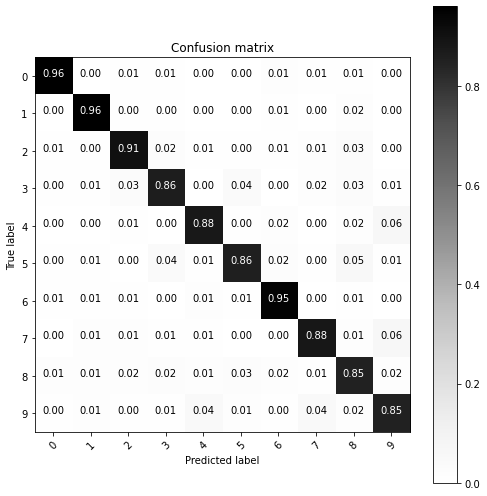

In [ ]:
loss, acc = net.model.evaluate(x_test, y_test, verbose=False);
predictions = net.model.predict(x_test)
print("Test done!\n\tMean accuracy: {}\n\tLoss: {}".format(acc, loss))

cm = confusion_matrix(y_test, np.argmax(predictions, axis=1))
plot_confusion_matrix(cm, [str(n) for n in range(0, 10)], normalize=True)

## Compute uncertainties for MNIST

In [ ]:
predictions_uncertainty, predicted_class_variances = compute_uncertainties(net, x_test)
title = "MNIST test - All predictions"
plot = MyPlot(1, 1, (8,5))
my_histogram(plot.axes, predicted_class_variances, 'b', title)

title = "MNIST test - False predictions"
plot = MyPlot(1, 1, (8,5))
not_corret_preds = predicted_class_variances[y_test != np.argmax(predictions, axis=1)]
my_histogram(plot.axes, not_corret_preds, 'r', title)

(10000, 10)


## Deterministic net for MNIST as comparison

###########
Model built
###########

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/5
422/422 [==============================] - 2s 5ms/step - loss: 0.1937 - accuracy: 0.9410 - val_loss: 0.0602 - val_accuracy: 0.9813

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/5
422/422 [==============================] - 2s 4ms/step - loss: 0.0530 - accuracy: 0.9839 - val_loss: 0.0432 - val_accuracy: 0.9870

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/5
422/422 [==============================] - 2s 4ms/step - loss: 0.0363 - accuracy: 0.9888 - val_loss: 0.0370 - val_accuracy: 0.9887

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/5
422/422 [==============================] - 2s 4ms/step - loss: 0.0271 - accuracy: 0.9912 - val_loss: 0.0373 - val_accuracy: 0.9890

Epoch 00005: LearningRateScheduler reducing learning rate t

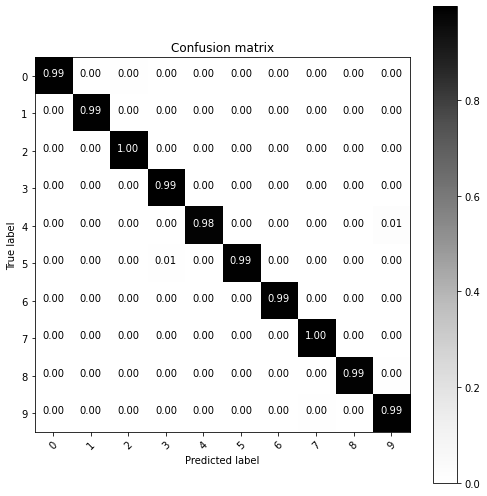

In [ ]:
epochs = 5
learning_rate = 0.001
batch_size = 128
input_shape = x_train[0].shape
net_deterministic = MyNet(epochs, 
                          batch_size, 
                          learning_rate,
                          input_shape,
                          n_classes = len(n_classes),
                          model=None)
history = net_deterministic.train_model(x_train, y_train)
loss, acc = net_deterministic.model.evaluate(x_test, y_test, verbose=False);
predictions = net_deterministic.model.predict(x_test)
print("Test done!\n\tMean accuracy: {}\n\tLoss: {}".format(acc, loss))

cm = confusion_matrix(y_test, np.argmax(predictions, axis=1))
plot_confusion_matrix(cm, [str(n) for n in range(0, 10)], normalize=True)

# EMNIST

In [ ]:
!wget http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip
!unzip matlab.zip

emnist = spio.loadmat(os.path.join("matlab", "emnist-letters"))

x_train_emnist = emnist["dataset"][0][0][0][0][0][0]
x_train_emnist = np.squeeze(x_train_emnist.astype(np.float32))
y_train_emnist = np.squeeze(emnist["dataset"][0][0][0][0][0][1])
x_test_emnist = emnist["dataset"][0][0][1][0][0][0]
x_test_emnist = x_test_emnist.astype(np.float32)
y_test_emnist = np.squeeze(emnist["dataset"][0][0][1][0][0][1])
x_train_emnist /= 255
x_test_emnist /= 255
x_train_emnist = x_train_emnist.reshape(x_train_emnist.shape[0], 28, 28, order="A")
x_test_emnist = x_test_emnist.reshape(x_test_emnist.shape[0], 28, 28, order="A")

x_train_emnist = np.expand_dims(x_train_emnist, axis=-1)
x_test_emnist = np.expand_dims(x_test_emnist, axis=-1)
fake_labels = np.zeros((len(x_test_emnist), 10))

--2020-12-06 11:07:47--  http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip
Resolving www.itl.nist.gov (www.itl.nist.gov)... 132.163.4.36, 2610:20:6b01:4::36
Connecting to www.itl.nist.gov (www.itl.nist.gov)|132.163.4.36|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip [following]
--2020-12-06 11:07:47--  https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip
Connecting to www.itl.nist.gov (www.itl.nist.gov)|132.163.4.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 743900280 (709M) [application/zip]
Saving to: ‘matlab.zip’

matlab.zip          100%[===================>] 709.44M  98.4MB/s    in 7.4s    

2020-12-06 11:07:55 (96.4 MB/s) - ‘matlab.zip’ saved [743900280/743900280]

Archive:  matlab.zip
  inflating: matlab/emnist-balanced.mat  
  inflating: matlab/emnist-byclass.mat  
  inflating: matlab/emnist-bymerge.mat  
  inflating: matlab/em

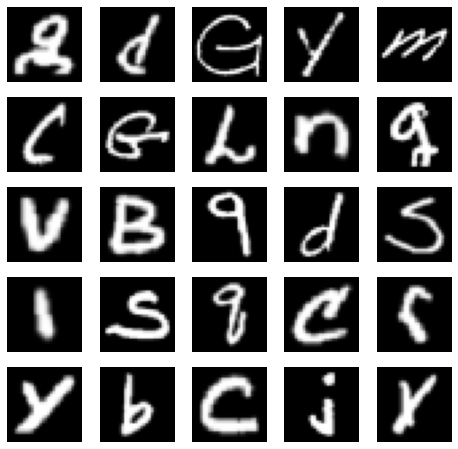

In [ ]:
plot_random_images(np.squeeze(x_train_emnist), 25)

## Compute uncertainties for EMNIST 

(20800, 10)


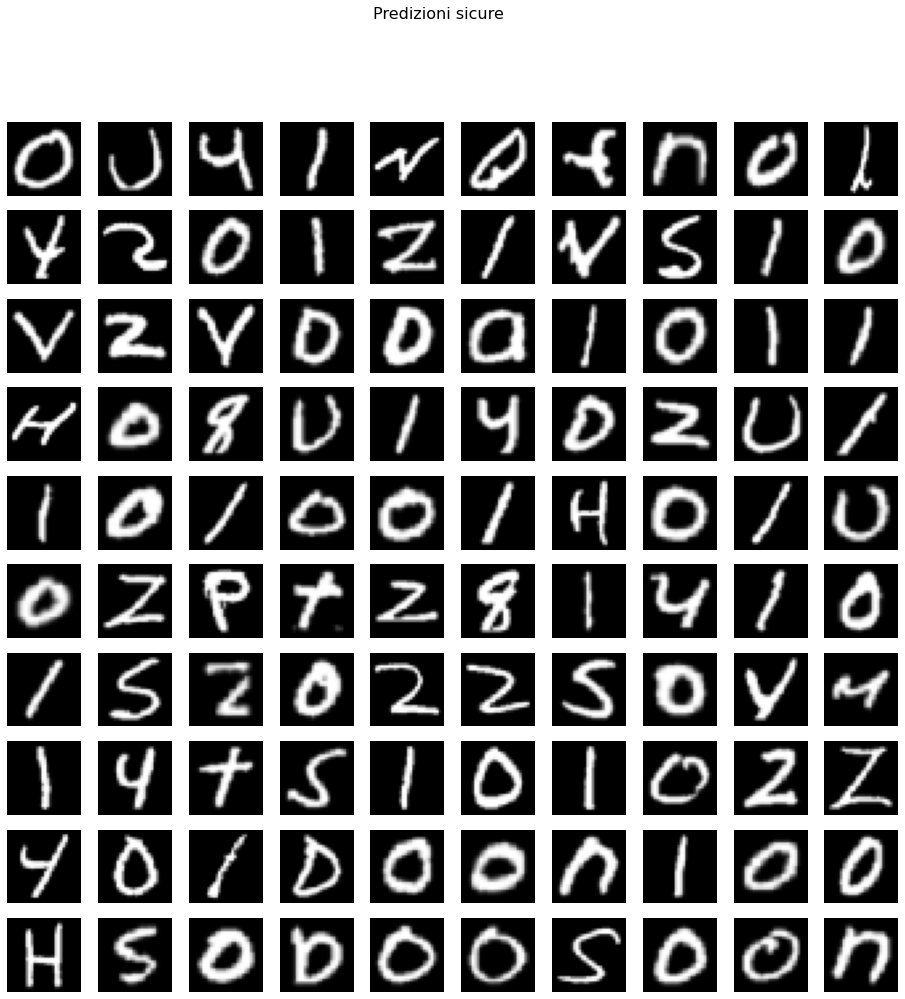

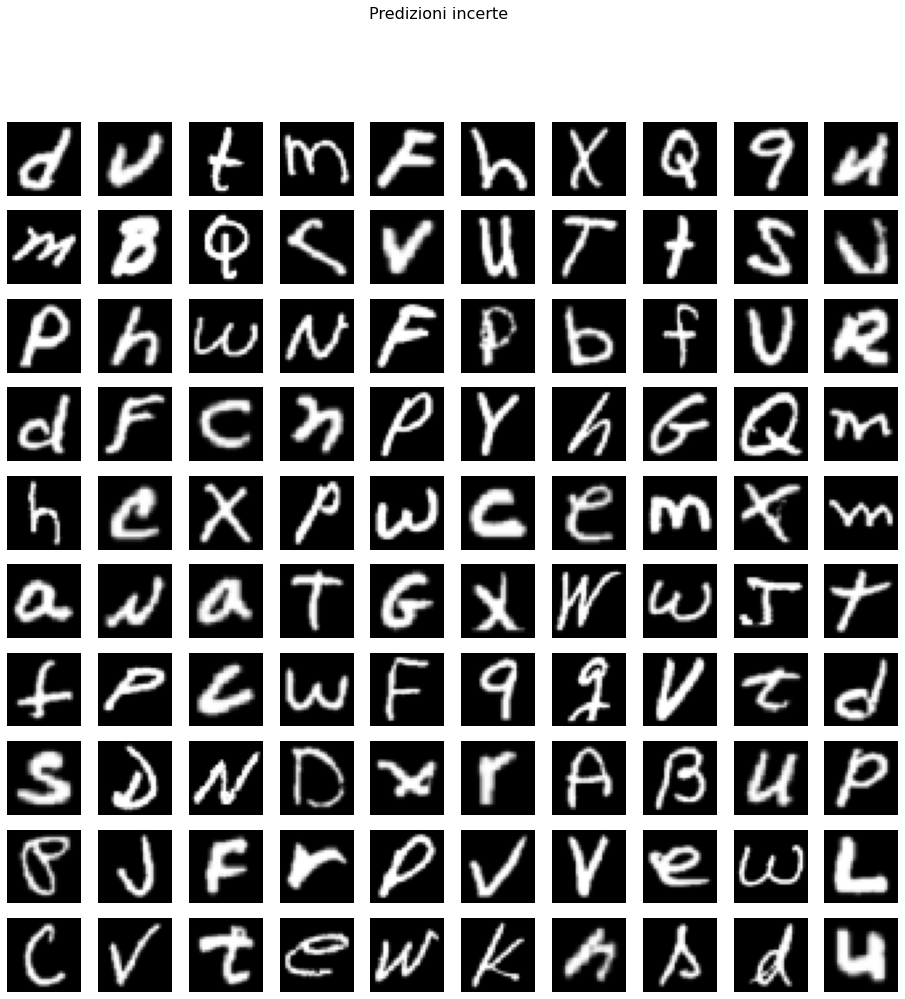

In [ ]:
predictions_uncertainty, predicted_class_variances = compute_uncertainties(net, x_test_emnist)
title = "EMNIST test - All predictions"
plot = MyPlot(1, 1, (8, 5))
my_histogram(plot.axes, predicted_class_variances, 'b', title)

title = "EMNIST test - All predictions - softmax uncertainty"
plot = MyPlot(1, 1, (8, 5))
my_histogram(plot.axes, predicted_class_variances, 'b', title)

sure = np.where(predicted_class_variances < 0.05)[0]
title = "Predizioni sicure"
plot_random_images(np.squeeze(x_test_emnist[sure]), examples=100, fig_suptitle=title, figsize=(16, 16))

uncertain = np.where(predicted_class_variances > 0.22)[0]
title = "Predizioni incerte"
plot_random_images(np.squeeze(x_test_emnist[uncertain]), examples=100, fig_suptitle=title, figsize=(16, 16))

## Softmax uncertainty

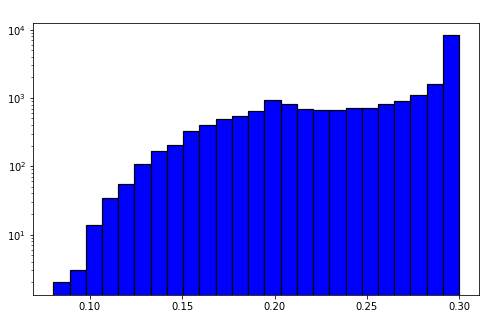

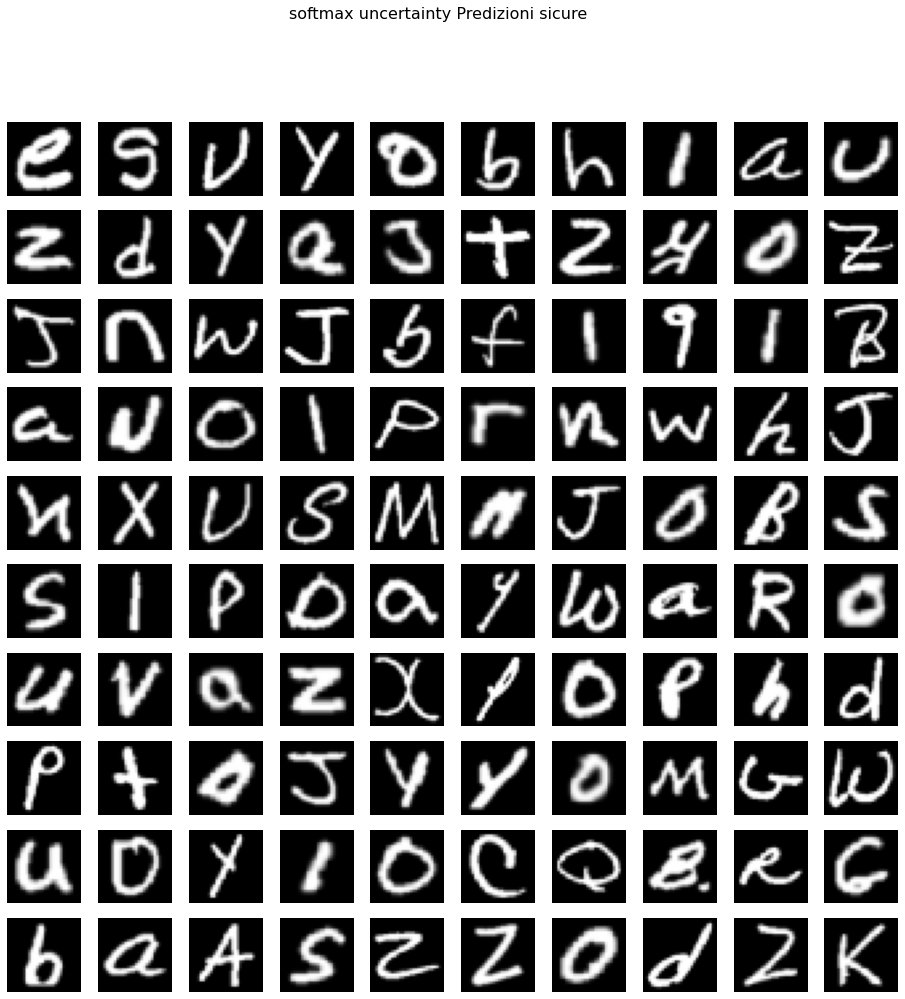

In [ ]:
softmax_uncertainty = compute_uncertainties_softmax(net_deterministic,
                                                    x_test_emnist)

title = "EMNIST test - All predictions - softmax uncertainty"
plot = MyPlot(1, 1, (8, 5))
my_histogram(plot.axes, softmax_uncertainty, 'b', title)

sure = np.where(softmax_uncertainty < 0.15)[0]
title = "softmax uncertainty Predizioni incerte"
plot_random_images(np.squeeze(x_test_emnist[sure]), examples=100, fig_suptitle=title, figsize=(16, 16))

uncertain = np.where(softmax_uncertainty > 0.26)[0]
title = "softmax uncertainty Predizioni sicure"
plot_random_images(np.squeeze(x_test_emnist[uncertain]), examples=100, fig_suptitle=title, figsize=(16, 16))

# Biological dataset

#########################
VGG16 model dropout built
#########################

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 1/75
64/64 [==============================] - 3s 49ms/step - loss: 1.6815 - accuracy: 0.3340 - val_loss: 1.0848 - val_accuracy: 0.3656

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 2/75
64/64 [==============================] - 3s 40ms/step - loss: 1.0864 - accuracy: 0.3353 - val_loss: 1.0761 - val_accuracy: 0.3833

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 3/75
64/64 [==============================] - 3s 40ms/step - loss: 1.0773 - accuracy: 0.3535 - val_loss: 1.0637 - val_accuracy: 0.4122

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 4/75
64/64 [==============================] - 3s 40ms/step - loss: 1.0581 - accuracy: 0.3988 - val_loss: 1.0414 - val_accuracy: 0.4300

Epoch 00005: Lear

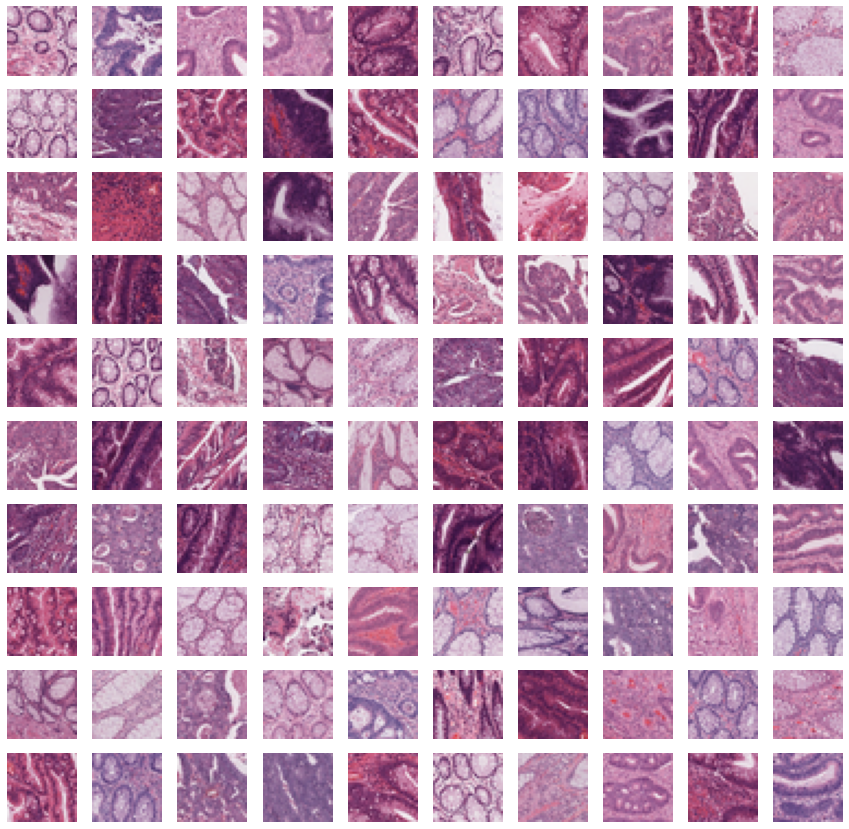

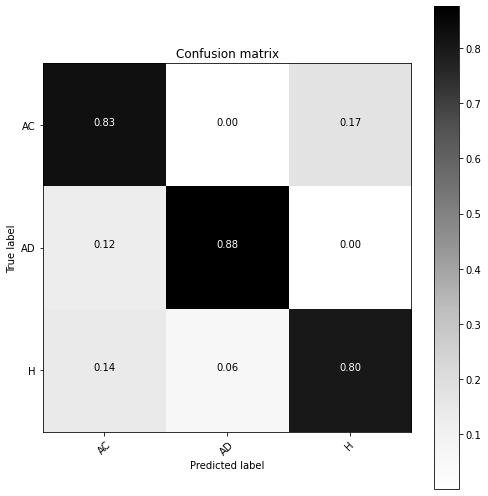

In [ ]:
import requests, zipfile, io
#The copied URL goes here ->
r = requests.get("https://github.com/FrPo/crc_3_classi_64x64/blob/master/crc_3_classi.zip?raw=true") 
zip_file = zipfile.ZipFile(io.BytesIO(r.content))
zip_file.extractall()
X_train_bio = np.load("/content/train_X.npy")
Y_train_bio = np.load("/content/train_Y.npy")
X_test_bio = np.load("/content/test_X.npy")
Y_test_bio = np.load("/content/test_Y.npy")
plot_random_images(X_train_bio, 100, figsize=(15, 15))

mean_image = np.mean(X_train_bio, axis=(0, 1, 2))
X_train_norm = (X_train_bio - mean_image) / 255
X_test_norm = (X_test_bio - mean_image) / 255

epochs = 75
# Train the MC Dropout model
net = MyNet(epochs, 
            batch_size, 
            learning_rate=.0001,
            lr_reduction_epoch=60,
            mc_dropout_rate=0.4,
            input_shape=X_train_bio[0].shape,
            n_classes = len(np.unique(Y_train_bio)),
            model="VGG16_dropout")
history = net.train_model(X_train_bio, Y_train_bio)
predictions = net.model.predict(X_test_bio)
cm = confusion_matrix(Y_test_bio, np.argmax(predictions, axis=1))
plot_confusion_matrix(cm, ["AC", "AD", "H"], normalize=True)

Computing uncertainties
(9000, 3)


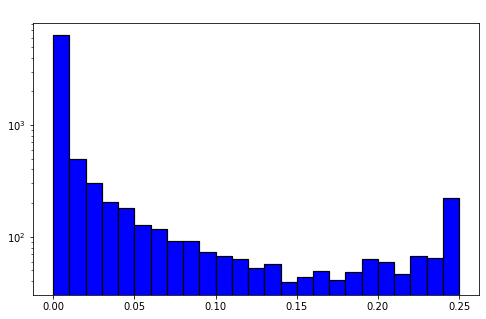

In [ ]:
print("Computing uncertainties")
predictions_uncertainty, predicted_class_variances = compute_uncertainties(net, 
                                                                           X_train_bio)
title = "EMNIST test - All predictions - Uncertainty"
plot = MyPlot(1, 1, (8, 5))
my_histogram(plot.axes, predicted_class_variances, 'b', title)

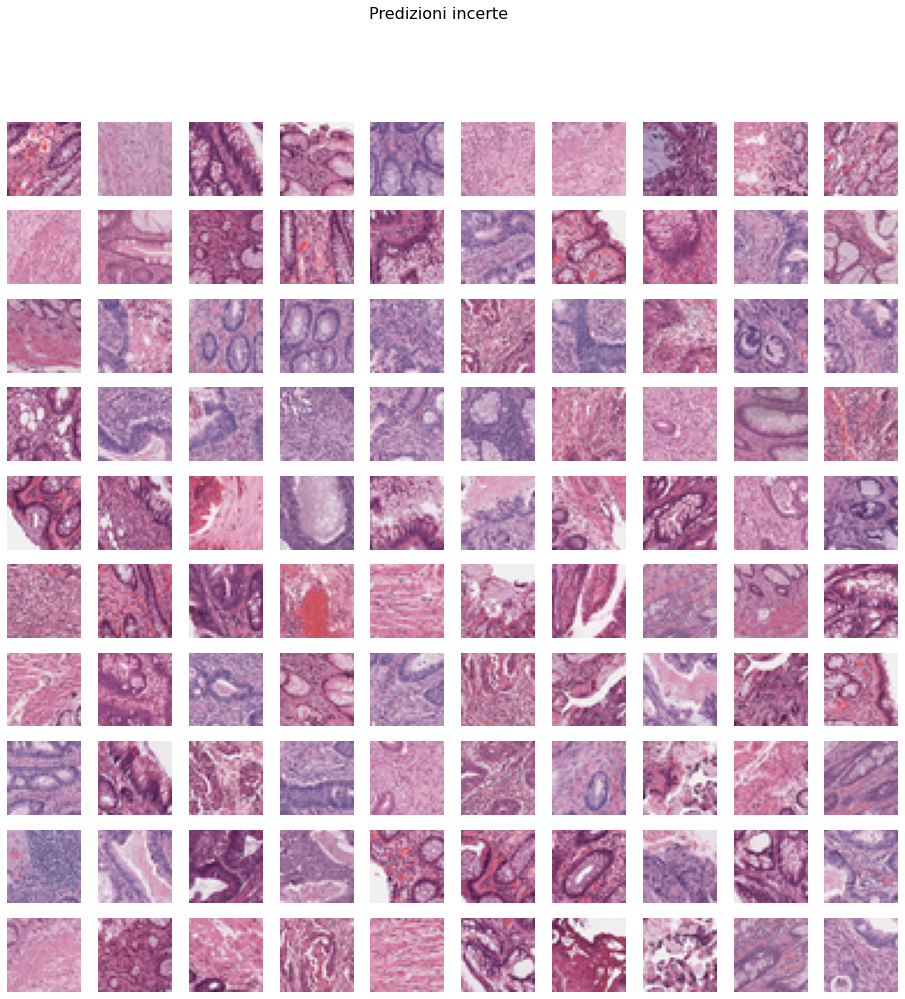

In [ ]:
uncertain = np.where(predicted_class_variances > 0.22)[0]
title = "Predizioni incerte"
plot_random_images(np.squeeze(X_train_bio[uncertain]), examples=100, fig_suptitle=title, figsize=(16, 16))